# LightGBM Sin Stock

In [18]:
import pandas as pd # Data handling and managing
import numpy as np  # Handiling linear Algera
import seaborn as sn
import datetime 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb #xgboost model
import pmdarima as pm
import lightgbm as lgb

%matplotlib inline

In [19]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [51]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase2.xlsx')
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset

#dataset=dataset[dataset['Producto']==1]

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana
0,2015-06-29,1,3629,0,4.394742,0,0
1,2015-06-30,1,4666,0,4.394742,0,0
2,2015-07-01,1,16070,0,4.394742,0,0
3,2015-07-02,1,4666,0,4.394742,0,0
4,2015-07-03,1,8813,0,4.394742,0,0
...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0
140542,2021-03-20,99,0,0,4.394742,0,1
140543,2021-03-21,99,0,0,4.394742,0,1
140544,2021-03-22,99,0,0,4.394742,0,0


In [52]:
#Tratamiento Outliers
Q1_ventas=dataset['udsVenta'].quantile(0.25)
Q3_ventas=dataset['udsVenta'].quantile(0.75)
IQR_ventas=Q3_ventas-Q1_ventas

Limit_lower=Q1_ventas-(1.5*IQR_ventas)
Limit_upper=Q3_ventas+(1.5*IQR_ventas)

dataset=dataset[~((dataset["udsVenta"] < Limit_lower) |(dataset["udsVenta"] > Limit_upper))]


Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [53]:
#División TEST y TRAINING
X_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1)
y_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019'), 'udsVenta']

X_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1).reset_index(drop=True)
y_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019'), 'udsVenta'].reset_index(drop=True)

In [ ]:
#Busqueda parametros optimos
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003,0.5],
    'max_depth': [-1, 3, 5],
    'n_estimators': [100, 200, 500,1000],
}

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

reg = lgb.LGBMRegressor(random_state=0)

grid.best_params_

In [54]:
#Aplicación del modelo con parametros optimos

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 5,
    "num_leaves": 7,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 100
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

C:\Users\subir\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.03, max_bin=512, max_depth=5,
              metric=['l2', 'auc'], num_iterations=100000, num_leaves=7,
              objective='regression', task='train', verbose=0)

In [58]:
#Evaluacion resultados

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
from sklearn.metrics import mean_squared_log_error


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 180872.86
RMSE: 425.29


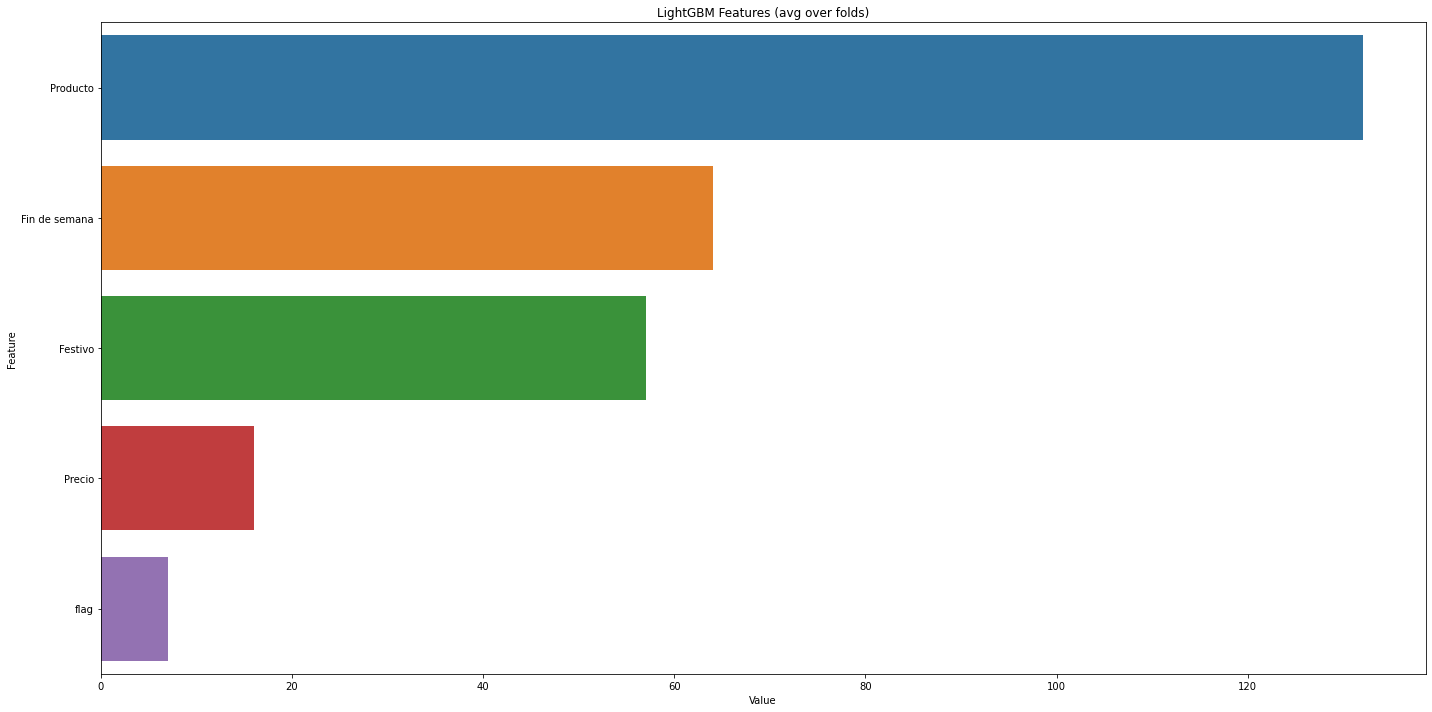

In [59]:
#Peso variables

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

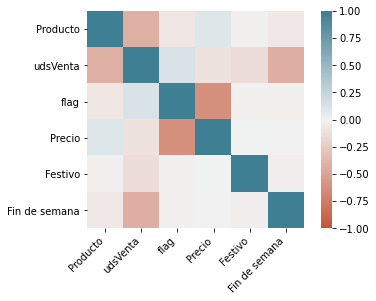

In [26]:
corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [60]:
#Muestra dataset con variable predicha
resultat = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')]
resultat['prediccion']=y_pred
resultat

<ipython-input-60-260e7441cdfe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultat['prediccion']=y_pred


,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana,prediccion
1648,2019-12-31,1,691,0,3.910500,0,0,982.452928
1649,2020-01-01,1,0,0,3.910500,1,0,305.094794
1652,2020-01-04,1,346,0,3.910500,0,1,252.814070
1653,2020-01-05,1,0,0,3.910500,0,1,252.814070
1654,2020-01-06,1,0,0,3.910500,1,0,305.094794
...,...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0,284.756291
140542,2021-03-20,99,0,0,4.394742,0,1,163.810151
140543,2021-03-21,99,0,0,4.394742,0,1,163.810151
140544,2021-03-22,99,0,0,4.394742,0,0,284.756291


# LightGBM con variables extras

In [27]:
import pandas as pd # Data handling and managing
import numpy as np  # Handiling linear Algera
import seaborn as sn
import datetime 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb #xgboost model
import pmdarima as pm
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [61]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase3.xlsx')
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana,sales_lag_7,sales_lag_15,sales_lag_30,...,sales_lag_300,sales_lag_330,sales_lag_360,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,Mes,Dia,DiaDeLaSemana,Año
0,2019-02-20,1,1555,0,4.138200,0,0,0,1555,518,...,0,0,0,121.425704,94.570180,86.954522,2,20,2,2019
1,2019-02-23,1,1037,0,4.138200,0,1,1037,1037,0,...,0,0,0,122.785716,95.307368,87.471774,2,23,5,2019
2,2019-02-24,1,0,0,4.138200,0,1,0,0,0,...,0,0,0,124.180002,96.063975,88.001770,2,24,6,2019
3,2019-02-27,1,1037,0,4.138200,0,0,518,1037,0,...,0,0,0,125.577704,96.826398,88.532477,2,27,2,2019
4,2019-03-02,1,518,0,4.138200,0,1,0,0,1037,...,0,0,0,127.009914,97.594623,89.063859,3,2,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105951,2021-03-19,99,540,0,4.394742,0,0,0,0,756,...,0,0,0,198.518439,218.510439,201.719088,3,19,4,2021
105952,2021-03-20,99,0,0,4.394742,0,1,0,0,0,...,540,0,108,197.608648,218.441607,201.748880,3,20,5,2021
105953,2021-03-21,99,0,0,4.394742,0,1,0,0,0,...,0,0,0,196.698856,218.366616,201.782522,3,21,6,2021
105954,2021-03-22,99,0,0,4.394742,0,0,0,0,0,...,810,0,0,195.789065,218.287277,201.817988,3,22,0,2021


In [62]:
Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [30]:
#Solo para buscar parametros optimos
#dataset = dataset.sample(frac=0.20)

In [63]:
X_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1)
y_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019'), 'udsVenta']

X_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1).reset_index(drop=True)
y_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019'), 'udsVenta'].reset_index(drop=True)

In [32]:
#Solo para buscar parametros optimos
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

params = {
    'num_leaves': [7, 14, 21,  31, 50],
    'learning_rate': [0.1, 0.03, 0.5],
    'max_depth': [3, 5, 10],
    'n_estimators': [200, 500,1000],
}

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

reg = lgb.LGBMRegressor(random_state=0)

In [33]:
#Solo para buscar parametros optimos
grid.best_estimator_
grid.best_params_

{'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}

In [64]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 50,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 200
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

C:\Users\subir\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, col

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.03, max_bin=512, max_depth=10,
              metric=['l2', 'auc'], n_estimators=200, num_iterations=100000,
              num_leaves=50, objective='regression', task='train', verbose=0)

In [65]:
#Evaluacion resultados

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
from sklearn.metrics import mean_squared_log_error


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 195765.56
RMSE: 442.45


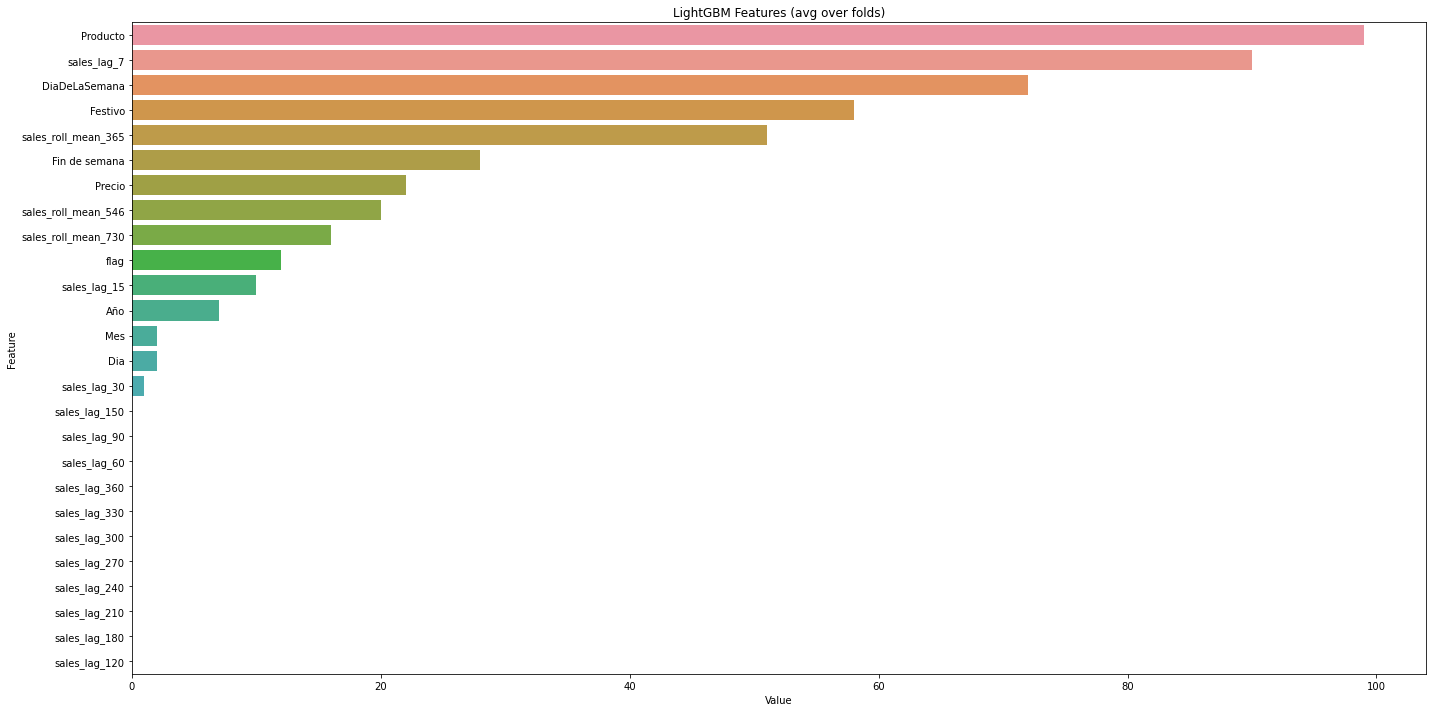

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

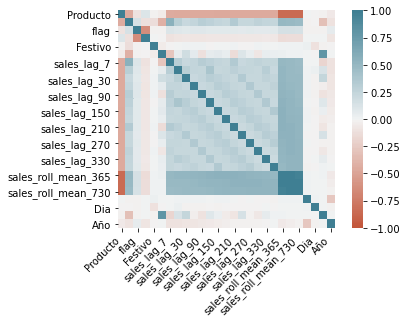

In [17]:
corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [49]:
dataset

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana
5,2015-07-04,1,0,0,4.394742,0,1
6,2015-07-05,1,0,0,4.394742,0,1
12,2015-07-11,1,0,0,4.394742,0,1
13,2015-07-12,1,0,0,4.394742,0,1
19,2015-07-18,1,0,0,4.394742,0,1
...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0
140542,2021-03-20,99,0,0,4.394742,0,1
140543,2021-03-21,99,0,0,4.394742,0,1
140544,2021-03-22,99,0,0,4.394742,0,0
